In [33]:
from graph_analyser import GranGapEstimater
from graph_analyser import GranLinker

from graph_structure import KnowledgeGraph

In [34]:
import stanza

In [35]:
import io
import os
import pylab
import numpy as np
import networkx as nx
from tqdm import tqdm

In [36]:
from nltk import windowdiff
from nltk import pk

In [5]:
syntax_graph = KnowledgeGraph()
syntax_graph.load("old_thesaurus_graph")
estimator = GranGapEstimater(syntax_graph)

In [98]:
syntax_graph = KnowledgeGraph()
syntax_graph.load("vspu_2019_graph_3_3_links_for_norm_dset")
estimator = GranGapEstimater(syntax_graph)

Теперь надо загрузить текст, разбить на пердложения и посчитать промежутки между соседними предложениями

In [29]:
def calculate_gaps_for_sentences(sentences, estimation_method,
                                 args = {}):
    gaps = []
    for sentence_ind in range(len(sentences) - 1):
        gap = estimation_method(
            sentences[sentence_ind],
            sentences[sentence_ind + 1],
            **args)
        gap += estimation_method(
            sentences[sentence_ind],
            sentences[sentence_ind + 1],
            **args)
        gap /= 2.0
        gaps.append(gap)
    return gaps

In [30]:
def predict_breaks(gaps, segment_break_cutoff):
    segment_breaks = []
    for elm in range(len(gaps)):
        if gaps[elm] > segment_break_cutoff: # должно же быть > ?!
            segment_breaks.append(True)
        else:
            segment_breaks.append(False)
    segment_breaks = np.array(segment_breaks)
    return segment_breaks

In [37]:
parser = stanza.Pipeline(lang='ru', processors='tokenize,lemma')

2024-03-20 00:32:33 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-03-20 00:32:33 INFO: Loading these models for language: ru (Russian):
| Processor | Package            |
----------------------------------
| tokenize  | syntagrus          |
| lemma     | syntagrus_nocharlm |

2024-03-20 00:32:33 INFO: Using device: cuda
2024-03-20 00:32:33 INFO: Loading: tokenize
2024-03-20 00:32:39 INFO: Loading: lemma
2024-03-20 00:32:39 INFO: Done loading processors!


In [38]:
def load_testing_sample(fname, normalize = True):
    with io.open(fname, "r", encoding='utf-8') as f:
        text_ = f.read()
    sentences = text_.split("\n")

    sentences_without_breaks = []
    true_segment_breaks = []
    prev_sent = None
    for sent in sentences:
        if sent.strip() != "":
            if sent != "--- SEGMENT BRAKE ---":
                if normalize:
                    sent_norm_text = ""
                    try:
                        doc = parser(sent).sentences[0]
                        for elm in doc.words:
                            sent_norm_text += elm.lemma + ' '
                    except IndexError as err:# это встретилось пустое предложение
                        raise err
                else:
                    sent_norm_text = sent
                sentences_without_breaks.append(sent_norm_text)
        
                if prev_sent is not None:
                    if prev_sent == "--- SEGMENT BRAKE ---":
                        true_segment_breaks.append(True)
                    else:
                        true_segment_breaks.append(False)
            prev_sent = sent
    true_segment_breaks = np.array(true_segment_breaks)
    return true_segment_breaks, sentences_without_breaks

### ==============

In [39]:
def find_matching_for_testing_file(sentences_without_breaks, true_segment_breaks, gaps, cutoff, windsize = 3):
    predicted_segment_breaks = predict_breaks(gaps, cutoff)
    t_seg = ''.join(str(int(sb)) for sb in true_segment_breaks)
    seg = ''.join(str(int(sb)) for sb in predicted_segment_breaks)
    
    wnd = windowdiff(''.join(str(int(sb)) for sb in true_segment_breaks), 
                     ''.join(str(int(sb)) for sb in predicted_segment_breaks), windsize)
    pk_ = pk(''.join(str(int(sb)) for sb in true_segment_breaks), 
             ''.join(str(int(sb)) for sb in predicted_segment_breaks), windsize)
    
    return wnd, pk_, t_seg, seg

In [40]:
def find_full_matching_for_testing_file(sentences_without_breaks, true_segment_breaks, gaps, cutoff):
    predicted_segment_breaks = predict_breaks(gaps, cutoff)
    
    matching = (predicted_segment_breaks == true_segment_breaks).mean()
    wnd = windowdiff(''.join(str(int(sb)) for sb in true_segment_breaks), 
                     ''.join(str(int(sb)) for sb in predicted_segment_breaks), 3)
    pk_ = pk(''.join(str(int(sb)) for sb in true_segment_breaks), 
             ''.join(str(int(sb)) for sb in predicted_segment_breaks), 3)
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(len(predicted_segment_breaks)):
        if true_segment_breaks[i] == True:
            if predicted_segment_breaks[i] == True:
                tp += 1
            else:
                fn += 1
        else:
            if predicted_segment_breaks[i] == True:
                fp += 1
            else:
                tn += 1
    p = 0 if tp == 0 else tp / (tp + fp)
    r = 0 if tp == 0 else tp / (tp + fn)
    f1 = 0 if tp == 0 else 2 * p*r / (p + r)
    return (matching, p, r, f1, wnd, pk_), gaps

In [41]:
def plot_cutoffs(cutoffs_to_mean_match):
    pylab.figure(figsize = (12,8))
    pylab.plot(cutoffs_to_mean_match[:,0], cutoffs_to_mean_match[:,1], label = "wind", color = "magenta")
    pylab.plot(cutoffs_to_mean_match[:,0], cutoffs_to_mean_match[:,2], label = "pk")
    pylab.plot([cutoffs_to_mean_match[:,0][0], cutoffs_to_mean_match[:,0][-1]], 
               [min(cutoffs_to_mean_match[:,1]), min(cutoffs_to_mean_match[:,1])], "--", color = "magenta", linewidth = 0.6)
    pylab.legend()
    pylab.show()

def plot_full_cutoffs(cutoffs_to_mean_match):
    pylab.figure(figsize = (12,8))
    pylab.plot(cutoffs_to_mean_match[:,0], cutoffs_to_mean_match[:,1], label = "matching")
    pylab.plot(cutoffs_to_mean_match[:,0], cutoffs_to_mean_match[:,4], label = "f1")
    pylab.plot(cutoffs_to_mean_match[:,0], cutoffs_to_mean_match[:,5], label = "wind", color = "magenta")
    pylab.plot(cutoffs_to_mean_match[:,0], cutoffs_to_mean_match[:,6], label = "pk")
    pylab.plot([cutoffs_to_mean_match[:,0][0], cutoffs_to_mean_match[:,0][-1]], 
               [min(cutoffs_to_mean_match[:,5]), min(cutoffs_to_mean_match[:,5])], "--", color = "magenta", linewidth = 0.6)
    pylab.legend()
    pylab.show()

In [224]:
texts_directory = "segmentation_dataset"

all_true_breaks = []
all_sentences_without_breaks = []
for fname in tqdm(os.listdir(texts_directory)):
    path = texts_directory + "/" + fname
    true_breaks, sentences_without_breaks = load_testing_sample(path, normalize = True)
    all_true_breaks.append(true_breaks)
    all_sentences_without_breaks.append(sentences_without_breaks)

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [01:21<00:00,  1.27s/it]


In [205]:
texts_directory = "new_segmentation_dataset"

all_true_breaks = []
all_sentences_without_breaks = []
for fname in tqdm(sorted(os.listdir(texts_directory), key = lambda x: int(x[:-4]))):
    path = texts_directory + "/" + fname
    true_breaks, sentences_without_breaks = load_new_testing_sample(path, normalize = False)
    all_true_breaks.append(true_breaks)
    all_sentences_without_breaks.append(sentences_without_breaks)
    
all_true_segmentations = []
for true_break in all_true_breaks:
    all_true_segmentations.append(''.join([str(int(b)) for b in true_break]))

100%|████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 4497.72it/s]


## Расстояния только по графу без весов

In [225]:
texts_directory = "segmentation_dataset"

params_g = {"no_path_weight" : 1}
params_l = {"dist_weight_weight" : 1.5,
         "sem_weight_weight" : 1.5,
         "entropy_weight" : 2}

params_self = {"subgraph_inflation" : 0,
               "zero_overlay_result" : 0,
               "graph_distance_weight" : 0.5,
               "link_distance_weight" : 1.5,
               "graph_distance_finder_params" : params_g,
               "link_distance_finder_params" : params_l,
               "node_detection_method" : "native"
               }

# calculate gaps
# then go threw cutoffs

gaps_for_all = []

for i in tqdm(range(len(all_true_breaks))):
    
    sentences_without_breaks = all_sentences_without_breaks[i]
    gaps = calculate_gaps_for_sentences(sentences_without_breaks, 
                                        estimator.estimate_gap_combined_distance, 
                                        args = params_self)
    gaps_for_all.append(gaps)

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:33<00:00,  1.91it/s]


In [226]:
wd_s = []
pk_s = []
tsegs = []
segs = []
for i in range(len(all_true_breaks)):
    gaps = gaps_for_all[i]
    true_segment_breaks = all_true_breaks[i]
    
    wd_, pk_, tseg, seg = find_matching_for_testing_file(sentences_without_breaks, 
                                              true_segment_breaks, 
                                              gaps, 
                                              cutoff = np.array(gaps).mean() + np.array(gaps).std())
            
    wd_s = np.array(wd_)
    pk_s = np.array(pk_)
    tsegs.append(tseg)
    segs.append(seg)

wd_s_mean = wd_s.mean()
pk_s_mean = pk_s.mean()

In [227]:
print(wd_s_mean)
print(pk_s_mean)

0.5571428571428572
0.5428571428571428


In [228]:
for i in range(len(segs)):
    print(tsegs[i])
    print(segs[i])
    print()

000100001000100010001000100001000100010000100001000100010000100010000
001010001000100000100000000000000110000101000000100000000010000000000

00001000010001000010000100001000010000100001000010000100001000100010000
00101000110100000000000011010000010010000000000000000100000000000101000

0001000010000100010000100010001000010000100010001000011000100010001000
0101001100001000000000100010000000000000100000000000000000000000001010

000100001000100001100001000100001000010001000100010001000010001000010000
100000000000100001000000010001000001000000000000000000000000100000100000

000010001000100010001000010000100010000100010001000010001000100010000
010000000001000100010000000000000100000000000000110100000010000000000

000010000100001000100001000100001000100001000100001000010000100010000
010010000000010000010000001000100000010000100000010001100100000000000

0000100010001000010001000100001000010001000100010000100001000100010000
1000000000000011010100000000000001100000010100000000000001001100000000


#### Генерируем массив со случайными значениями, подобными гапам

In [229]:
import random

In [230]:
all_gaps = np.array([gap  for gaps in gaps_for_all for gap in gaps])
generated_gaps_mean = all_gaps.mean()
generated_gaps_std = all_gaps.std()

In [231]:
gaps_density = np.array([[value, len([gap for gap in all_gaps if abs(gap - value) < 0.002]) / 0.002] 
                        for value in np.arange(all_gaps.mean() - 0.5, all_gaps.mean() + 0.5, 0.002)])

In [232]:
arr = np.random.normal(loc=generated_gaps_mean,
                       scale=generated_gaps_std,
                       size=500000)

In [233]:
arr_density = np.array([[value, len([gap for gap in arr[0:len(all_gaps)] if abs(gap - value) < 0.002]) / 0.002] 
                        for value in np.arange(arr[0:len(all_gaps)].mean() - 0.5, arr[0:len(all_gaps)].mean() + 0.5, 0.002)])

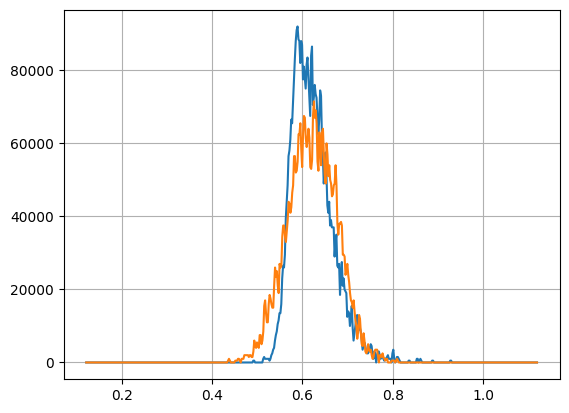

In [234]:
pylab.plot(gaps_density[:,0], gaps_density[:,1])
pylab.plot(arr_density[:,0], arr_density[:,1])
pylab.grid()
pylab.show()

# Бейслайны

### Простой IOU

In [185]:
texts_directory = "segmentation_dataset"

params_g = {"no_path_weight" : 0}
params_l = {"dist_weight_weight" : 0,
         "sem_weight_weight" : 0,
         "entropy_weight" : 0}

params_self = {"subgraph_inflation" : 0,
               "graph_distance_weight" : 0,
               "link_distance_weight" : 0,
               "graph_distance_finder_params" : params_g,
               "link_distance_finder_params" : params_l}

params_self = {
    "subgraph_inflation" : 1
}


# calculate gaps
# then go threw cutoffs

# all_true_breaks = []
# all_sentences_without_breaks = []
# for fname in os.listdir(texts_directory):
#     path = texts_directory + "/" + fname
#     true_breaks, sentences_without_breaks = load_testing_sample(path)
#     all_true_breaks.append(true_breaks)
#     all_sentences_without_breaks.append(sentences_without_breaks)
gaps_for_all = []

for i in tqdm(range(len(all_true_breaks))):
    
    sentences_without_breaks = all_sentences_without_breaks[i]
    gaps = calculate_gaps_for_sentences(sentences_without_breaks, 
                                        estimator.estimate_gap_simple, 
                                        args = params_self)
    gaps_for_all.append(gaps)

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.06it/s]


In [265]:
wd_s = []
pk_s = []
for i in range(len(all_true_breaks)):
    gaps = gaps_for_all[i]
    true_segment_breaks = all_true_breaks[i]
    
    wd_, pk_ = find_matching_for_testing_file(sentences_without_breaks, 
                                              true_segment_breaks, 
                                              gaps, 
                                              cutoff = np.array(gaps).mean() + np.array(gaps).std())
            
    wd_s = np.array(wd_)
    pk_s = np.array(pk_)

wd_s_mean = wd_s.mean()
pk_s_mean = pk_s.mean()

In [266]:
print(f"{wd_s_mean:.3f}")
print(f"{pk_s_mean:.3f}")

0.529
0.529


## Эмбединги языковой модели

In [237]:
for i in tqdm(range(len(all_true_breaks))):
    
    sentences_without_breaks = all_sentences_without_breaks[i]
    gaps = calculate_gaps_for_sentences(sentences_without_breaks, 
                                        estimator.estimate_gap_lm_only, 
                                        args = params_self)
    gaps_for_all.append(gaps)

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:51<00:00,  1.21it/s]


In [240]:
wd_s = []
pk_s = []
for i in range(len(all_true_breaks)):
    gaps = gaps_for_all[i]
    true_segment_breaks = all_true_breaks[i]
    
    wd_, pk_ = find_matching_for_testing_file(sentences_without_breaks, 
                                              true_segment_breaks, 
                                              gaps, 
                                              cutoff = np.array(gaps).mean() + np.array(gaps).std())
            
    wd_s = np.array(wd_)
    pk_s = np.array(pk_)

wd_s_mean = wd_s.mean()
pk_s_mean = pk_s.mean()

In [241]:
print(f"{wd_s_mean:.3f}")
print(f"{pk_s_mean:.3f}")

0.529
0.412


### Исследование сегментации

In [11]:
texts_directory = "segmentation_dataset"

all_true_breaks = []
all_sentences_without_breaks = []
for fname in tqdm(os.listdir(texts_directory)):
    path = texts_directory + "/" + fname
    true_breaks, sentences_without_breaks = load_testing_sample(path, normalize = False)
    all_true_breaks.append(true_breaks)
    all_sentences_without_breaks.append(sentences_without_breaks)
    
all_true_segmentations = []
for true_break in all_true_breaks:
    all_true_segmentations.append(''.join([str(int(b)) for b in true_break]))

100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 1138.89it/s]


In [92]:
gaps_for_all = []

for i in tqdm(range(len(all_true_breaks))):
    
    sentences_without_breaks = all_sentences_without_breaks[i]
    gaps = calculate_gaps_for_sentences(sentences_without_breaks, 
                                        estimator.estimate_gap_lm_only
                                        )
    gaps_for_all.append(gaps)

  0%|                                                                                           | 0/63 [00:00<?, ?it/s]


NameError: name 'estimator' is not defined

In [91]:
wd_s = []
pk_s = []
segmentations = []
ncms = []
for i in (range(len(all_sentences_without_breaks))):
    doc = all_sentences_without_breaks[i]
    seg = all_true_segmentations[i]
    gaps = gaps_for_all[i]
    segmentation = ''.join(str(int(sb)) for sb in predict_breaks(gaps, np.array(gaps).mean() +
                                                                 np.array(gaps).std()))
    segmentations.append(segmentation)
    
    wd_s.append(windowdiff(seg, segmentation, 3))
    pk_s.append(pk(seg, segmentation, 3))

wd_mean = np.array(wd_s).mean()
pk_mean = np.array(pk_s).mean()

In [27]:
print(f"wd mean {wd_mean}")
print(f"pk mean {pk_mean}")

wd mean 0.5299308667817704
pk mean 0.45643597963883503


In [21]:
for i in range(len(segmentations)):
    print(f"pred:\t{segmentations[i]}")
    print(f"true:\t{all_true_segmentations[i]}")
    print("============================================")

pred:	000000001000111100011110000000000100000000000100010001010001000000010
true:	000100001000100010001000100001000100010000100001000100010000100010000
pred:	00000000000000000000000000000000000001110000000010000000000000000010100
true:	00001000010001000010000100001000010000100001000010000100001000100010000
pred:	0000000000000000000000000000000000000001000110000000000000001000100000
true:	0001000010000100010000100010001000010000100010001000011000100010001000
pred:	000000000000100000000000000001000000000011000000000000000001101000000001
true:	000100001000100001100001000100001000010001000100010001000010001000010000
pred:	000000000000100000100000010000100010011001000000000010000010000110100
true:	000010001000100010001000010000100010000100010001000010001000100010000
pred:	110000000000000000000000110000000000000000000000000000000000110100000
true:	000010000100001000100001000100001000100001000100001000010000100010000
pred:	0101000000000000000001100000000000011000100100000000000000000011000000

In [40]:
correct_breaks = []
missed_braks = []
for i in range(len(segmentations)):
    for pos in range(1, len(segmentations[i]) -1):
        seg = all_true_segmentations[i]
        if segmentations[i][pos] == seg[pos] and seg[pos] == "1" and\
           segmentations[i][pos - 1] == seg[pos - 1] and seg[pos - 1] == "0" and\
           segmentations[i][pos + 1] == seg[pos + 1] and seg[pos + 1] == "0":
            
           correct_breaks.append(
               [ all_sentences_without_breaks[i][pos - 1],
                all_sentences_without_breaks[i][pos],
                "============SEGBREAK============== ",
                all_sentences_without_breaks[i][pos + 1],
                all_sentences_without_breaks[i][pos + 2]]
           )      
        if segmentations[i][pos] != seg[pos] and seg[pos] == "1" and\
           segmentations[i][pos - 1] == seg[pos - 1] and seg[pos - 1] == "0" and\
           segmentations[i][pos + 1] == seg[pos + 1] and seg[pos + 1] == "0":
            
           missed_braks.append(
               [ all_sentences_without_breaks[i][pos - 1],
                all_sentences_without_breaks[i][pos],
                "============SEGBREAK============== ",
                all_sentences_without_breaks[i][pos + 1],
                all_sentences_without_breaks[i][pos + 2]]
           )          
            

In [39]:
correct_breaks

[['Главы компании ПАО Сбербанк утверждают что вопросами безопасности занимаются лучшие специалисты ими создаются квалифицированные команды по борьбе с киберпреступностью',
  'Несмотря на множество специализированных компаний по предотвращению киберугроз ПАО Сбербанк самостоятельно занимается вопросами кибербезопасности защищая не только денежные средства своих клиентов но и персональную информацию Поскольку банк владеет огромной базой данных клиентов то в первоочередном порядке сталкивается с новейшими видами угроз от изобретательных злоумышленников',
  '============SEGBREAK============== ',
  'При увеличении порядка системы во первых возрастает трудоемкость и во вторых ввиду усложнения структуры множества достижимости затрудняется его исследование',
  'б для всех узлов расчетные минимальное и максимальное значения аппроксимации функции цены На отрезке во всех узлах проводится выбор из сгенерированного набора во первых оптимального программного управления и вовторых управления на котор

In [41]:
missed_braks

[['Далее будем предполагать что для каждой координаты существует компонента вектора т е т и',
  'В постановочной части эта задача была изложена в',
  '============SEGBREAK============== ',
  'Это позволяет обществу быть более бдительным и не попадаться на уловки злоумышленников',
  'Уже многие компании ориентированы на аудиторию в виртуальном мире'],
 ['В последнее время эта проблема решается с помощью внедрения в учебный процесс технологий компьютерного обучения',
  'При этом для демонстрации принципов работы последовательности и технологии сборки узлов автомобиля используются виртуальные модели деталей сборочных единиц и инструментов разработанные в системе',
  '============SEGBREAK============== ',
  'Разрабатываемая система обеспечивает к примеру решение задач формирования системы образовательных услуг региона округа района т е задач требующих при решении географической привязки к местности',
  'Вторым принципом решения является обеспечение возможности объединения информации размещ

In [ ]:
# find exact matches
# where start and end of a segment are correct
# find fuzzy matches
# where start or end aer one off
# 

## TF-IDF

In [267]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [268]:
def cos_gap(vec_1, vec_2):
    return cosine_similarity([vec_1], [vec_2])[0][0]

In [269]:
params_self = {}
vectorizer = TfidfVectorizer()

gaps_for_all = []

for i in tqdm(range(len(all_true_breaks))):
    
    sentences_without_breaks = all_sentences_without_breaks[i]
    vecs = vectorizer.fit_transform(sentences_without_breaks).toarray()
    gaps = calculate_gaps_for_sentences(vecs, 
                                        cos_gap, 
                                        args = params_self)
    gaps_for_all.append(gaps)

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 24.54it/s]


In [270]:
wd_s = []
pk_s = []
for i in range(len(all_true_breaks)):
    gaps = gaps_for_all[i]
    true_segment_breaks = all_true_breaks[i]
    
    wd_, pk_ = find_matching_for_testing_file(sentences_without_breaks, 
                                              true_segment_breaks, 
                                              gaps, 
                                              cutoff = np.array(gaps).mean() + np.array(gaps).std())
            
    wd_s = np.array(wd_)
    pk_s = np.array(pk_)

wd_s_mean = wd_s.mean()
pk_s_mean = pk_s.mean()

In [271]:
print(f"{wd_s_mean:.3f}")
print(f"{pk_s_mean:.3f}")

0.529
0.471


## Случайные промежутки

In [235]:
def generate_random_gap(_,__):
    return random.choice(all_gaps)

## Исследоание распределения метода со случайными промежутками

In [236]:
wd_means = []
pk_means = []

for _ in tqdm(range(1000)):

    gaps_for_all = []
    for i in range(len(all_true_breaks)):
        sentences_without_breaks = all_sentences_without_breaks[i]
        gaps = calculate_gaps_for_sentences(sentences_without_breaks, 
                                            generate_random_gap, 
                                            args = {})
        gaps_for_all.append(gaps)
    
    wd_s = []
    pk_s = []
    
    for i in range(len(all_true_breaks)):
        gaps = gaps_for_all[i]
        #print(np.array(gaps).mean() + np.array(gaps).std())
        true_segment_breaks = all_true_breaks[i]
        
        wd_, pk_, _, _ = find_matching_for_testing_file(sentences_without_breaks, 
                                                  true_segment_breaks, 
                                                  gaps, 
                                                  cutoff = np.array(gaps).mean() + np.array(gaps).std())
                
        wd_s.append(wd_)
        pk_s.append(pk_)
    
    wd_means.append(np.array(wd_s).mean())
    pk_means.append(np.array(pk_s).mean())
    
wd_means = np.array(wd_means)
pk_means = np.array(pk_means)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.56it/s]


In [237]:
base_wd_mean = 0.557
base_pk_mean = 0.543

In [238]:
wd_density = np.array([[value, len([wd_mean for wd_mean in wd_means if abs(wd_mean - value) < 0.002 ])] 
                   for value in np.arange(wd_means.mean() - 0.5, wd_means.mean() + 0.5, 0.002)])

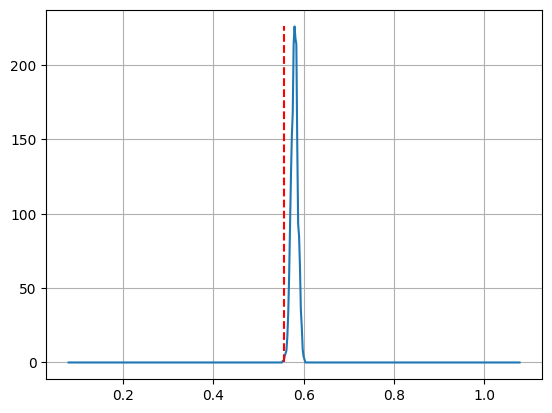

In [239]:
pylab.plot(wd_density[:,0], wd_density[:,1])
pylab.plot([base_wd_mean,base_wd_mean],[0,max(wd_density[:,1])],color = "red",linestyle = "--")
pylab.grid()
pylab.show()

In [240]:
pk_density = np.array([[value, len([pk_mean for pk_mean in pk_means if abs(pk_mean - value) < 0.002 ])] 
                        for value in np.arange(pk_means.mean() - 0.5, pk_means.mean() + 0.5, 0.002)])

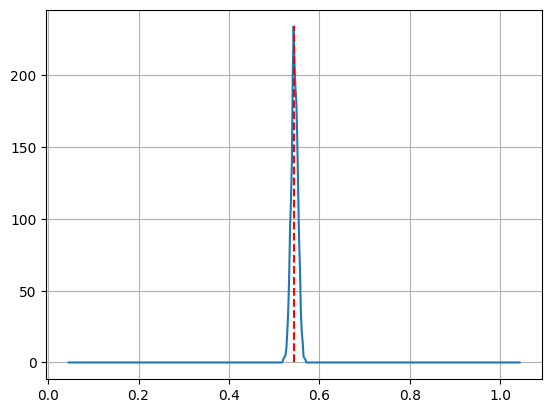

In [241]:
pylab.plot(pk_density[:,0], pk_density[:,1])
pylab.plot([base_pk_mean,base_pk_mean],[0,max(pk_density[:,1])],color = "red",linestyle = "--")
pylab.grid()
pylab.show()

====================================================================================

integrate 1/(0.0088 * sqrt(2pi))*e^(-0.5*((x-0.472)/0.0088)^2) dx from -inf to x=0.440

In [242]:
print(wd_means.mean(), wd_means.std())
print(pk_means.mean(), pk_means.std())

0.5797921440793831 0.00717641585233112
0.545294370219605 0.007403441869580551


### На основе тезауруса (старого)

In [16]:
old_thes_graph = KnowledgeGraph()
old_thes_graph.load("old_thesaurus_graph")
thes_estimator = GranGapEstimater(old_thes_graph)

In [17]:
texts_directory = "segmentation_dataset"

params_g = {"no_path_weight" : 1}
params_l = {"dist_weight_weight" : 1.5,
         "sem_weight_weight" : 1,
         "entropy_weight" : 1}

params_self = {"subgraph_inflation" : 0,
               "graph_distance_weight" : 0.5,
               "link_distance_weight" : 1,
               "zero_overlay_result" : 0,
               "graph_distance_finder_params" : params_g,
               "link_distance_finder_params" : params_l,
               "node_detection_method" : "parser"}

# calculate gaps
# then go threw cutoffs
gaps_for_all = []

# all_true_breaks = []
# all_sentences_without_breaks = []
# for fname in os.listdir(texts_directory):
#     path = texts_directory + "/" + fname
#     true_breaks, sentences_without_breaks = load_testing_sample(path)
#     all_true_breaks.append(true_breaks)
#     all_sentences_without_breaks.append(sentences_without_breaks)

for i in tqdm(range(len(all_true_breaks))):
    
    sentences_without_breaks = all_sentences_without_breaks[i]
    gaps = calculate_gaps_for_sentences(sentences_without_breaks, 
                                        thes_estimator.estimate_gap_combined_distance, 
                                        args = params_self)
    gaps_for_all.append(gaps)

  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

created distance graph


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:44<00:00,  1.42it/s]


In [18]:
cutoffs_to_mean_match = []

for cutoff in tqdm(np.arange(0,1,0.01)):
    
    wnds = []
    pk_s = []
    for i in range(len(all_true_breaks)):
        gaps = gaps_for_all[i]
        true_segment_breaks = all_true_breaks[i]
        
        
        wnd, pk_ = find_matching_for_testing_file(sentences_without_breaks, true_segment_breaks, gaps, cutoff)
        
        wnds.append(wnd)
        pk_s.append(pk_)
        
    wnds = np.array(wnds)
    pk_s = np.array(pk_s)
    cutoffs_to_mean_match.append([cutoff, wnds.mean(), pk_s.mean()])

cutoffs_to_mean_match = np.array(cutoffs_to_mean_match)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 78.29it/s]


In [19]:
print(f"min windowdiff\t\t{cutoffs_to_mean_match[:,1].min()}")
print(f"min pk\t\t\t{cutoffs_to_mean_match[:,2].min()}")
print(f"opt_cutoff\t\t{cutoffs_to_mean_match[cutoffs_to_mean_match[:,1].argmin()][0]}")

min windowdiff		0.5971737824538442
min pk			0.5139733312336526
opt_cutoff		0.26


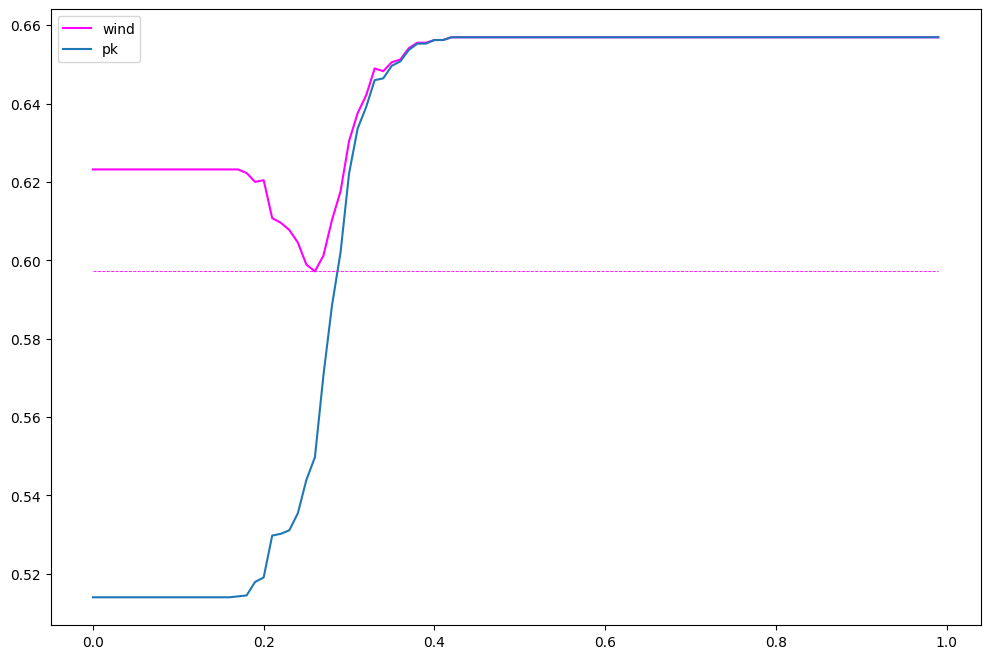

In [20]:
plot_cutoffs(cutoffs_to_mean_match)

# Куммулятивные графы

In [1]:
import io
import os
import json
import pylab
import numpy as np
import networkx as nx
from tqdm import tqdm
from copy import deepcopy as cp

In [2]:
from graph_builder import GraphBuilder

In [3]:
from nltk import windowdiff
from nltk import pk

In [4]:
def load_new_testing_sample(fname, normalize = True):
    with io.open(fname, "r", encoding='utf-8') as f:
        text_ = f.read()
    sentences = text_.split("\n")

    sentences_without_breaks = []
    true_segment_breaks = []
    prev_sent = None
    i = 0
    for sent in sentences:
        if sent.strip() != "":
            # if prev_sent is not None:
            #     print(sent[0:20])
            #     print(prev_sent[0:20])
            #     print("============================================")
            if prev_sent == "--- SEGMENT BRAKE ---":
                prev_sent = "--- SEGMENT BRAKE --- 1"
                # theme name
                continue
            if sent == "--- SEGMENT BRAKE ---":
                prev_sent = sent
                continue
                
                
            #====================================
            if normalize:
                sent_norm_text = ""
                try:
                    doc = parser(sent).sentences[0]
                    for elm in doc.words:
                        sent_norm_text += elm.lemma + ' '
                except IndexError as err:# это встретилось пустое предложение
                    raise err
            else:
                sent_norm_text = sent
            #====================================
            
            sentences_without_breaks.append(sent_norm_text)

            if prev_sent is not None:
                if prev_sent == "--- SEGMENT BRAKE --- 1":
                    true_segment_breaks.append(True)
                    # theme name
                else:
                    true_segment_breaks.append(False)

            prev_sent = sent
                        
                     
    true_segment_breaks = np.array(true_segment_breaks)
    return true_segment_breaks, sentences_without_breaks

In [5]:
texts_directory = "new_segmentation_dataset"

all_true_breaks = []
all_sentences_without_breaks = []
for fname in tqdm(sorted(os.listdir(texts_directory), key = lambda x: int(x[:-4]))):
    path = texts_directory + "/" + fname
    true_breaks, sentences_without_breaks = load_new_testing_sample(path, normalize = False)
    all_true_breaks.append(true_breaks)
    all_sentences_without_breaks.append(sentences_without_breaks)
    
all_true_segmentations = []
for true_break in all_true_breaks:
    all_true_segmentations.append(''.join([str(int(b)) for b in true_break]))

100%|█████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 194.76it/s]


In [6]:
def load_testing_sample(fname, normalize = True):
    with io.open(fname, "r", encoding='utf-8') as f:
        text_ = f.read()
    sentences = text_.split("\n")

    sentences_without_breaks = []
    true_segment_breaks = []
    prev_sent = None
    for sent in sentences:
        if sent.strip() != "":
            if sent != "--- SEGMENT BRAKE ---":
                if normalize:
                    sent_norm_text = ""
                    try:
                        doc = parser(sent).sentences[0]
                        for elm in doc.words:
                            sent_norm_text += elm.lemma + ' '
                    except IndexError as err:# это встретилось пустое предложение
                        raise err
                else:
                    sent_norm_text = sent
                sentences_without_breaks.append(sent_norm_text)
        
                if prev_sent is not None:
                    if prev_sent == "--- SEGMENT BRAKE ---":
                        true_segment_breaks.append(True)
                    else:
                        true_segment_breaks.append(False)
            prev_sent = sent
    true_segment_breaks = np.array(true_segment_breaks)
    return true_segment_breaks, sentences_without_breaks

In [16]:
texts_directory = "segmentation_dataset"

all_true_breaks = []
all_sentences_without_breaks = []
for fname in tqdm(sorted(os.listdir(texts_directory), key = lambda x: int(x[:-4]))):
    path = texts_directory + "/" + fname
    true_breaks, sentences_without_breaks = load_testing_sample(path, normalize = False)
    all_true_breaks.append(true_breaks)
    all_sentences_without_breaks.append(sentences_without_breaks)
    
all_true_segmentations = []
for true_break in all_true_breaks:
    all_true_segmentations.append(''.join([str(int(b)) for b in true_break]))

100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 1684.73it/s]


In [64]:
builder = GraphBuilder()

2024-03-18 16:33:49 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-03-18 16:33:53 INFO: Loading these models for language: ru (Russian):
| Processor | Package            |
----------------------------------
| tokenize  | syntagrus          |
| pos       | syntagrus_charlm   |
| lemma     | syntagrus_nocharlm |
| depparse  | syntagrus_charlm   |
| ner       | wikiner            |

2024-03-18 16:33:53 INFO: Using device: cuda
2024-03-18 16:33:53 INFO: Loading: tokenize
2024-03-18 16:33:53 INFO: Loading: pos
2024-03-18 16:33:53 INFO: Loading: lemma
2024-03-18 16:33:53 INFO: Loading: depparse
2024-03-18 16:33:54 INFO: Loading: ner
2024-03-18 16:33:55 INFO: Done loading processors!


In [65]:
def create_sentence_graphs(document):
    sentence_graphs = []
    document_frequencies = builder.calculate_df(document)

    for sentence_text in document:
        sentence_graph = builder.extract_noun_phrases(sentence_text, 
                                                      add_focus = list(builder.find_most_significant_words(sentence_text, 0.1,
                                                                                                           document_frequencies, 
                                                                                                           trace = False).keys()))
        sentence_graphs.append(sentence_graph)
    return sentence_graphs

In [66]:
all_sentence_graphs = []
for doc in tqdm(all_sentences_without_breaks):
    sentence_graphs = create_sentence_graphs(doc)
    all_sentence_graphs.append(sentence_graphs)

  0%|                                                                                           | 0/63 [00:00<?, ?it/s]2024-03-18 16:34:04 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-03-18 16:34:04 INFO: Loading these models for language: ru (Russian):
| Processor | Package            |
----------------------------------
| tokenize  | syntagrus          |
| lemma     | syntagrus_nocharlm |

2024-03-18 16:34:04 INFO: Using device: cuda
2024-03-18 16:34:04 INFO: Loading: tokenize
2024-03-18 16:34:04 INFO: Loading: lemma
2024-03-18 16:34:04 INFO: Done loading processors!
100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [22:29<00:00, 21.42s/it]


In [67]:
# with open("graphs_new", 'w') as f:
#     graphs = {}
    
#     json.dump({str(i) : [nx.node_link_data(g) for g in sentence_graphs] for i, sentence_graphs in enumerate(all_sentence_graphs)}, f)

In [7]:
with open("graphs_new", 'r') as f:
    graphs = json.load(f)
all_sentence_graphs = [[nx.node_link_graph(g) for g in graphs[i]] for i in graphs.keys()]

In [8]:
from utils import sigmoid

In [9]:
def compute_segmentation_for_document(document_num, trace = False,
                                      min_contact_points = 0,
                                      use_statistic_thresholds = False,
                                      penilise_cum_graph_size = False,
                                      dynamic_contact_threshold_multiplier = 0,
                                      random_source = None,
                                      do_skips = True):
        
    threshold_trace = []
    
    node_contact_array = []
        
    sentence_graphs = all_sentence_graphs[document_num]
    
    cum_graph = nx.Graph()
    segmentation = ""
    
    i = 0
    seg_len = 0
    while i < len(sentence_graphs):
        
        graph = sentence_graphs[i]
        if len(cum_graph.nodes()) == 0:
            node_contact_array.append(0)
            cum_graph.add_nodes_from(graph.nodes())
            cum_graph.add_edges_from(graph.edges())
            if i != 0:
                segmentation += "0"
                seg_len += 1
            i += 1
        else:
            node_contact_points = [node for node in graph.nodes if node in cum_graph]
            node_contact_ratio = len(node_contact_points) / len(graph.nodes) if len(graph.nodes) != 0 else 0
            
            node_contact_measure = node_contact_ratio if random_source is None else random.choice(random_source)
            
            contact_points_threshold = min_contact_points +\
                                        use_statistic_thresholds*(np.array(node_contact_array).mean() + np.array(node_contact_array).std()) +\
                                        (sigmoid(seg_len, c = dynamic_contact_threshold_multiplier) - 0.5)*2
            threshold_trace.append(contact_points_threshold)
            node_contact_array.append(node_contact_measure)
            
            if trace:
                print(f"\t{len(node_contact_points)}\t ({node_contact_points})")
            if node_contact_measure > contact_points_threshold:
                # type 1 merge
                cum_graph.add_nodes_from(graph.nodes())
                cum_graph.add_edges_from(graph.edges())
                segmentation += "0"
                seg_len += 1
                i += 1        
            else:
                if do_skips:
                    if i + 1 == len(sentence_graphs):
                        segmentation += "0"
                        seg_len += 1
                        break
                        
                    next_graph = sentence_graphs[i + 1]
                    # attempt to merge next graph
                    # if merged with next graph, current graph is added as well
                    node_contact_points = [node for node in next_graph.nodes if node in cum_graph]
                    node_contact_ratio = len(node_contact_points) / len(next_graph.nodes) if len(next_graph.nodes) != 0 else 0
                    
                    node_contact_measure = node_contact_ratio if random_source is None else random.choice(random_source)
                    
                    contact_points_threshold = min_contact_points + \
                                            use_statistic_thresholds*(np.array(node_contact_array).mean() + np.array(node_contact_array).std()) +\
                                            (sigmoid(seg_len, c = dynamic_contact_threshold_multiplier) - 0.5)*2
                    threshold_trace.append(contact_points_threshold)
                    node_contact_array.append(node_contact_measure)
                    
                    if trace:
                        print(f"\t\t{len(node_contact_points)}\t ({node_contact_points})")
                    if node_contact_measure > contact_points_threshold:
                        # type 2 merge
                        cum_graph.add_nodes_from(next_graph.nodes())
                        cum_graph.add_edges_from(next_graph.edges())
                        
                        cum_graph.add_nodes_from(graph.nodes())
                        cum_graph.add_edges_from(graph.edges())
                        segmentation += "00"
                        seg_len += 2
                        i += 2 # skip next graph (already checked)
                    else:
                        # missmatch
                        # stop accumulation, segment break
                        if penilise_cum_graph_size:
                            node_contact_array = []
                        if trace:
                            print("segbreak")
                        segmentation += "1"
                        seg_len = 0
                        cum_graph = nx.Graph()
                        i += 1 # next graph is considered as part of next segmentation 
                else:
                    # missmatch
                    # stop accumulation, segment break
                    if penilise_cum_graph_size:
                        node_contact_array = []
                    if trace:
                        print("segbreak")
                    segmentation += "1"
                    seg_len = 0
                    cum_graph = nx.Graph()
                    i += 1 # next graph is considered as part of next segmentation 
    return segmentation, threshold_trace                 
                    

In [24]:
trace = []

wd_s = []
pk_s = []
segmentations = []
threshold_traces = []
for i in (range(len(all_true_segmentations))):

    seg = all_true_segmentations[i]
    segmentation, threshold_trace = compute_segmentation_for_document(i, min_contact_points = 0, 
                                                     use_statistic_thresholds = False,
                                                     penilise_cum_graph_size = False,
                                                     dynamic_contact_threshold_multiplier = 0.0,
                                                     random_source = None,
                                                     do_skips = True)
    threshold_traces.append(threshold_trace)
    segmentations.append(segmentation)

    wd_s.append(windowdiff(seg, segmentation, 3))
    pk_s.append(pk(seg, segmentation, 3))

wd_mean = np.array(wd_s).mean()
pk_mean = np.array(pk_s).mean()
    

In [25]:
print(f"wd mean {wd_mean}")
print(f"pk mean {pk_mean}")

wd mean 0.4883740980970139
pk mean 0.45917722937657496


In [12]:
for s in zip(all_true_segmentations,segmentations,wd_s):
    print(s[0])
    print(s[1])
    print(s[2])
    print("================")

0000000100000010010000010001000100010000010010000001000000100000010010000
0100000100000001001010010001010010101010100101000001000000100101000010100
0.3380281690140845
0000000000000100100010010000100010000000100000010000000100000100000010000
1000000000000101000010100000100010000010000000010000000100000101010010100
0.23943661971830985
00000000100000010000010000001000010010000100001000000010000000100001000000
00000100000010000000010101010101010101010101010101010100100100000000010000
0.6527777777777778
0000000100010000010000010001000000010000010000000100000000001001000000
1010000101010000010100101010000001010000010100000100000101000101000100
0.4264705882352941
00000100010010001000000100100001000000100100000010000010000010000010000000
10000001010001001010101000100010101010101010000010101000101010101010000100
0.5555555555555556
0000000010000000100000001010000100010000000100100000100010000000100100
1010000010100001000000001010000001010001010101000000101010101010100010
0.4411764705882353
00000

In [92]:
trace = []
for mcp in tqdm(np.arange(0,0.5,0.01)):
    for dctm in np.arange(0,1,0.01):
        wd_s = []
        pk_s = []
        segmentations = []
        for i in (range(len(train_sent))):
            doc = train_sent[i]
            seg = train_gaps[i]
            segmentation = compute_segmentation_for_document(len(test_sent) + i, min_contact_points = mcp, dynamic_contact_threshold_multiplier = dctm)
            segmentations.append(segmentation)
            
            wd_s.append(windowdiff(seg, segmentation, 3))
            pk_s.append(pk(seg, segmentation, 3))
        
        wd_mean = np.array(wd_s).mean()
        pk_mean = np.array(pk_s).mean()
    
        trace.append([mcp, dctm, wd_mean, pk_mean])

trace = np.array(trace)

100%|███████████████████████████████████████████| 50/50 [03:50<00:00,  4.60s/it]


In [93]:
print(min(trace[:,2]))
print(trace[:,0:2][trace[:,2].argmin()])

0.46544472259141395
[0.   0.13]


In [91]:
test_gaps = all_true_segmentations[ : int(len(all_true_segmentations) / 2)]
train_gaps = all_true_segmentations[int(len(all_true_segmentations) / 2) :]

## Сравнение этого варианта со случайным аналогом (учет длин такой же, графы случайные)

In [26]:
wd_means = []
pk_means = []

for _ in tqdm(range(1000)):
    wd_s = []
    pk_s = []
    segmentations = []
    ncms = []
    for i in (range(len(all_sentences_without_breaks))):
        doc = all_sentences_without_breaks[i]
        seg = all_true_segmentations[i]
        segmentation, threshold_trace = compute_segmentation_for_document(i, min_contact_points = 0, 
                                                     use_statistic_thresholds = False,
                                                     penilise_cum_graph_size = False,
                                                     dynamic_contact_threshold_multiplier = 0,
                                                     random_source = arr,
                                                     do_skips = True)
        #ncms.append(ncm)
        segmentations.append(segmentation)
        
        wd_s.append(windowdiff(seg, segmentation, 3))
        pk_s.append(pk(seg, segmentation, 3))
    
    wd_mean = np.array(wd_s).mean()
    pk_mean = np.array(pk_s).mean()

    wd_means.append(wd_mean)
    pk_means.append(pk_mean)
wd_means = np.array(wd_means)
pk_means = np.array(pk_means)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:44<00:00,  4.46it/s]


In [27]:
print(wd_means.mean(), wd_means.std())
print(pk_means.mean(), pk_means.std())

0.484671762846858 0.007006212692937129
0.48280057745722316 0.007090910941006944


In [130]:
wd_density = np.array([[value, len([wd_mean for wd_mean in wd_means if abs(wd_mean - value) < 0.002 ])] 
                   for value in np.arange(wd_means.mean() - 0.1, wd_means.mean() + 0.1, 0.002)])

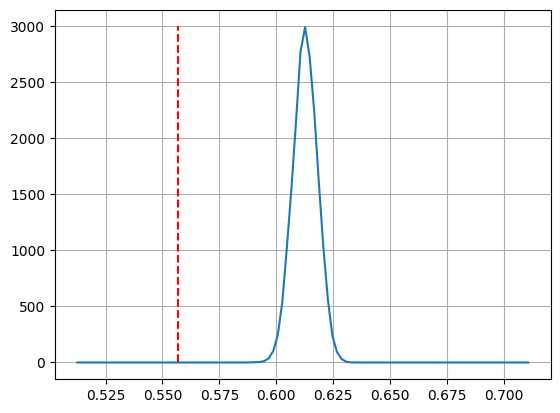

In [134]:
pylab.plot(wd_density[:,0], wd_density[:,1])
pylab.plot([base_wd_mean,base_wd_mean],[0,3000],color = "red",linestyle = "--")
pylab.grid()
pylab.show()

In [136]:
pk_density = np.array([[value, len([pk_mean for pk_mean in pk_means if abs(pk_mean - value) < 0.002 ])] 
                        for value in np.arange(pk_means.mean() - 0.13, pk_means.mean() + 0.1, 0.002)])

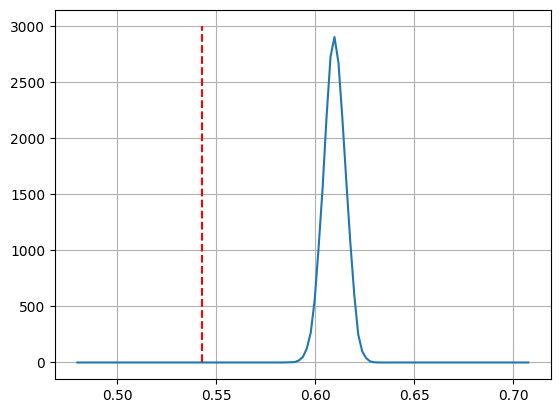

In [137]:
pylab.plot(pk_density[:,0], pk_density[:,1])
pylab.plot([base_pk_mean,base_pk_mean],[0,3000],color = "red",linestyle = "--")
pylab.grid()
pylab.show()

#### ===========================================

In [24]:
def probapility(sample, value):
    p_arr_cnt = 0
    for elm in sample:
        if elm - sample.mean() >= abs(value - sample.mean()):
            p_arr_cnt += 1
    return p_arr_cnt / len(sample)

In [57]:
print(f"p wd {probapility(wd_means, base_wd_mean)}")
print(f"p pk {probapility(wd_means, base_pk_mean)}")

p wd 0.0004
p pk 0.0


# Лучший вариант без учета длин

In [227]:
wd_s = []
pk_s = []
segmentations = []
for i in (range(len(all_sentences_without_breaks))):
    doc = all_sentences_without_breaks[i]
    seg = all_true_segmentations[i]
    segmentation, _ = compute_segmentation_for_document(i, min_contact_points = 0.14, dynamic_contact_threshold_multiplier = 0)
    segmentations.append(segmentation)
    
    wd_s.append(windowdiff(seg, segmentation, 3))
    pk_s.append(pk(seg, segmentation, 3))

wd_mean = np.array(wd_s).mean()
pk_mean = np.array(pk_s).mean()

In [228]:
print(f"wd mean {wd_mean}")
print(f"pk mean {pk_mean}")

wd mean 0.54977403681369
pk mean 0.42046400062030176


# Странные вещи

In [196]:
def compute_segmentation_for_document(document_num, trace = False,
                                           min_contact_points = 0,
                                           use_statistic_thresholds = False,
                                           penilise_cum_graph_size = False,
                                           dynamic_contact_threshold_multiplier = 0,
                                           arr = arr):
    threshold_trace = []
    
    node_contact_array = []
        
    sentence_graphs = all_sentence_graphs[document_num]
    
    cum_graph = nx.Graph()
    segmentation = ""
    
    i = 0
    seg_len = 0
    while i < len(sentence_graphs):
        
        graph = sentence_graphs[i]
        if len(cum_graph.nodes()) == 0:
            node_contact_array.append(0)
            cum_graph.add_nodes_from(graph.nodes())
            cum_graph.add_edges_from(graph.edges())
            if i != 0:
                segmentation += "0"
                seg_len += 1
            i += 1
        else:
            node_contact_points = [node for node in graph.nodes if node in cum_graph]
            node_contact_ratio = len(node_contact_points) / len(graph.nodes) if len(graph.nodes) != 0 else 0
            
            node_contact_measure = node_contact_ratio
            if penilise_cum_graph_size:
                node_contact_measure = node_contact_measure / len(cum_graph.nodes())
            contact_points_threshold = min_contact_points +\
                                        use_statistic_thresholds*(np.array(node_contact_array).mean() + np.array(node_contact_array).std()) +\
                                        (sigmoid(seg_len, c = dynamic_contact_threshold_multiplier) - 0.5)*2
            threshold_trace.append(contact_points_threshold)
            node_contact_array.append(node_contact_measure)
            
            if trace:
                print(f"\t{len(node_contact_points)}\t ({node_contact_points})")
            if node_contact_measure > contact_points_threshold:
                # type 1 merge
                cum_graph.add_nodes_from(graph.nodes())
                cum_graph.add_edges_from(graph.edges())
                segmentation += "0"
                seg_len += 1
                i += 1        
            else:
                # if i + 1 == len(sentence_graphs):
                #     segmentation += "0"
                #     seg_len += 1
                #     break
                    
                # next_graph = sentence_graphs[i + 1]
                # # attempt to merge next graph
                # # if merged with next graph, current graph is added as well
                # node_contact_points = [node for node in next_graph.nodes if node in cum_graph]
                # node_contact_ratio = len(node_contact_points) / len(next_graph.nodes) if len(next_graph.nodes) != 0 else 0
                
                # node_contact_measure = node_contact_ratio
                # if penilise_cum_graph_size:
                #     node_contact_measure = node_contact_measure / len(cum_graph.nodes())
                # contact_points_threshold = min_contact_points + \
                #                         use_statistic_thresholds*(np.array(node_contact_array).mean() + np.array(node_contact_array).std()) +\
                #                         (sigmoid(seg_len, c = dynamic_contact_threshold_multiplier) - 0.5)*2
                # threshold_trace.append(contact_points_threshold)
                # node_contact_array.append(node_contact_measure)
                
                # if trace:
                #     print(f"\t\t{len(node_contact_points)}\t ({node_contact_points})")
                # if node_contact_measure > contact_points_threshold:
                #     # type 2 merge
                #     cum_graph.add_nodes_from(next_graph.nodes())
                #     cum_graph.add_edges_from(next_graph.edges())
                    
                #     cum_graph.add_nodes_from(graph.nodes())
                #     cum_graph.add_edges_from(graph.edges())
                #     segmentation += "00"
                #     seg_len += 2
                #     i += 2 # skip next graph (already checked)
                # else:
                # missmatch
                # stop accumulation, segment break
                node_contact_array = []
                if trace:
                    print("segbreak")
                segmentation += "1"
                seg_len = 0
                cum_graph = nx.Graph()
                i += 1 # next graph is considered as part of next segmentation 
    return segmentation, threshold_trace                 
                    

In [197]:
wd_s = []
pk_s = []
segmentations = []
for i in (range(len(all_sentences_without_breaks))):
    doc = all_sentences_without_breaks[i]
    seg = all_true_segmentations[i]
    segmentation, _ = compute_segmentation_for_document(i, min_contact_points = 0, dynamic_contact_threshold_multiplier = 0.0)
    segmentations.append(segmentation)
    
    wd_s.append(windowdiff(seg, segmentation, 3))
    pk_s.append(pk(seg, segmentation, 3))

wd_mean = np.array(wd_s).mean()
pk_mean = np.array(pk_s).mean()

In [198]:
print(f"wd mean {wd_mean}")
print(f"pk mean {pk_mean}")

wd mean 0.522449191415705
pk mean 0.3720825845507236


# Проблема с учетом длин

In [1]:
def fixed_seg(doclen,seglen = 3):
    seg = ""
    for i in range(doclen):
        if i % seglen == 0:
            seg += "1"
        else:
            seg += "0"
    return seg

In [334]:
trace = []
for seglen in tqdm(np.arange(1,10,1)):
    wd_s = []
    pk_s = []
    segmentations = []
    for i in (range(len(all_sentences_without_breaks))):
        doc = all_sentences_without_breaks[i]
        seg = all_true_segmentations[i]
        segmentation = fixed_seg(len(seg), seglen)
        segmentations.append(segmentation)
        
        wd_s.append(windowdiff(seg, segmentation, 3))
        pk_s.append(pk(seg, segmentation, 3))
    
    wd_mean = np.array(wd_s).mean()
    pk_mean = np.array(pk_s).mean()

    trace.append([seglen, wd_mean, pk_mean])

trace = np.array(trace)

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 164.98it/s]


In [335]:
print(min(trace[:,1]))
print(trace[trace[:,1].argmin()])

0.3485847080064834
[3.         0.34858471 0.34306873]


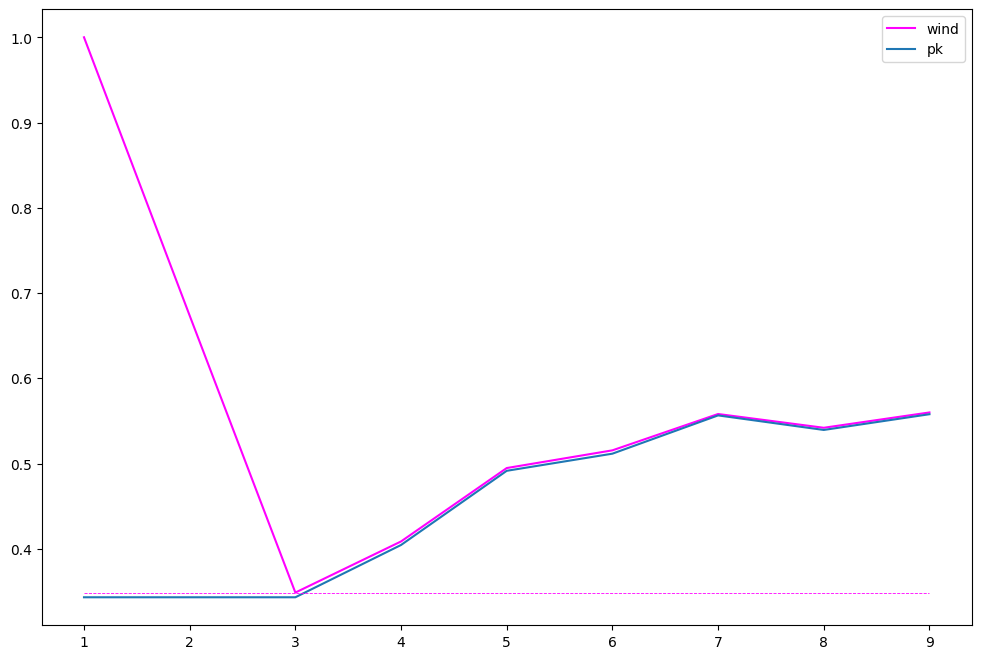

In [336]:
plot_cutoffs(trace)

# Истинно случайные сегментации

In [70]:
def rand_seg(doclen,part = 0.5):
    seg = ""
    for i in range(doclen):
        if random.random() > part:
            seg += "1"
        else:
            seg += "0"
    return seg

In [345]:
trace = []
for part in tqdm(np.arange(0,1,0.001)):
    wd_s = []
    pk_s = []
    segmentations = []
    for i in (range(len(all_sentences_without_breaks))):
        doc = all_sentences_without_breaks[i]
        seg = all_true_segmentations[i]
        segmentation = rand_seg(len(seg), part)
        segmentations.append(segmentation)
        
        wd_s.append(windowdiff(seg, segmentation, 3))
        pk_s.append(pk(seg, segmentation, 3))
    
    wd_mean = np.array(wd_s).mean()
    pk_mean = np.array(pk_s).mean()

    trace.append([part, wd_mean, pk_mean])

trace = np.array(trace)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.23it/s]


In [347]:
print(min(trace[:,1]))
print(trace[trace[:,1].argmin()])

0.5505586185011115
[0.803      0.55055862 0.48638449]


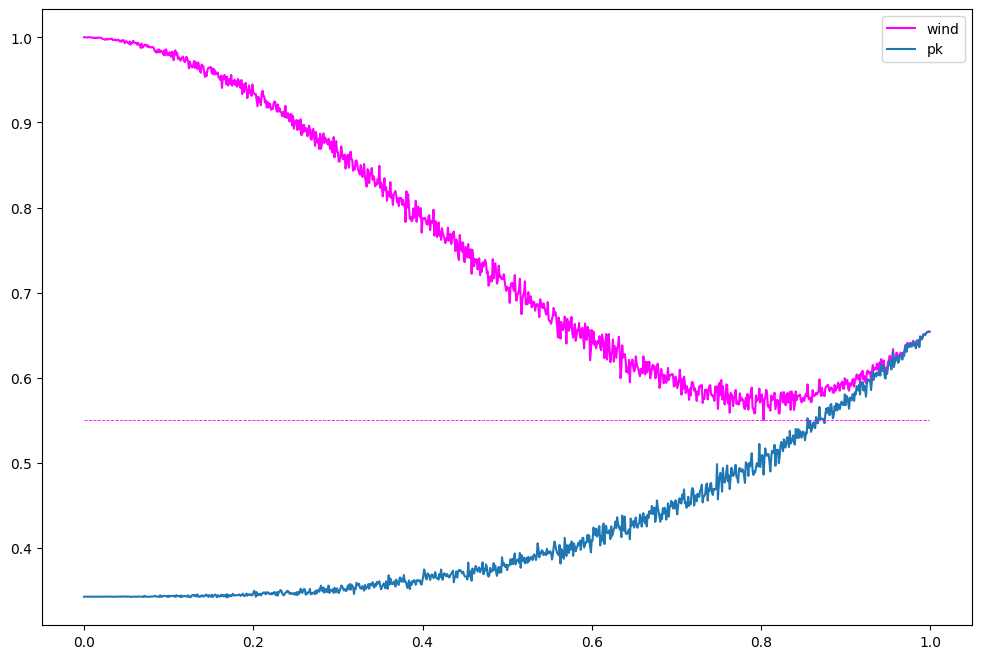

In [348]:
plot_cutoffs(trace)

## Случайные сегментации с учетом длин

In [15]:
import random
arr = np.random.normal(loc=0.10597712980861627,
                       scale=0.15921127300055313,
                       size=500000)

## Сегментим бертом

In [289]:
syntax_graph = KnowledgeGraph()
syntax_graph.load("old_thesaurus_graph")
estimator = GranGapEstimater(syntax_graph)

In [21]:
from utils import sigmoid

In [24]:
def compute_segmentation_for_document_bert(document_num, trace = False,
                                          min_contact_points = 0,
                                          use_statistic_thresholds = False,
                                          penilise_cum_graph_size = False,
                                          dynamic_contact_threshold_multiplier = 0,
                                          random_source = None,
                                          do_skips = True):
        
    threshold_trace = []
    
    node_contact_array = []
        
    texts = all_sentences_without_breaks[document_num]
    
    cum_text = ""
    segmentation = ""
    
    i = 0
    seg_len = 0
    while i < len(texts):
        
        text = texts[i]
        if len(cum_text) == 0:
            node_contact_array.append(0)
            cum_text+= " " + text
            if i != 0:
                segmentation += "0"
                seg_len += 1
            i += 1
        else:
            
            node_contact_measure = estimator.estimate_gap_lm_only(cum_text, text) if random_source is None else random.choice(random_source)
            
            contact_points_threshold = min_contact_points +\
                                        use_statistic_thresholds*(np.array(node_contact_array).mean() + np.array(node_contact_array).std()) +\
                                        (sigmoid(seg_len, c = dynamic_contact_threshold_multiplier) - 0.5)*2
            threshold_trace.append(contact_points_threshold)
            node_contact_array.append(node_contact_measure)
            
            if trace:
                print(f"\t{len(node_contact_points)}\t ({node_contact_points})")
            if node_contact_measure > contact_points_threshold:
                # type 1 merge
                cum_text+= " " + text
                segmentation += "0"
                seg_len += 1
                i += 1        
            else:
                if do_skips:
                    if i + 1 == len(texts):
                        segmentation += "0"
                        seg_len += 1
                        break
                        
                    next_text = texts[i + 1]
                    # attempt to merge next graph
                    # if merged with next graph, current graph is added as well
                    
                    node_contact_measure = estimator.estimate_gap_lm_only(cum_text, text) if random_source is None else random.choice(random_source)
                    
                    contact_points_threshold = min_contact_points + \
                                            use_statistic_thresholds*(np.array(node_contact_array).mean() + np.array(node_contact_array).std()) +\
                                            (sigmoid(seg_len, c = dynamic_contact_threshold_multiplier) - 0.5)*2
                    threshold_trace.append(contact_points_threshold)
                    node_contact_array.append(node_contact_measure)
                    
                    if trace:
                        print(f"\t\t{len(node_contact_points)}\t ({node_contact_points})")
                    if node_contact_measure > contact_points_threshold:
                        # type 2 merge
                        cum_text+= " " + text
                        cum_text+= " " + next_text
                        segmentation += "00"
                        seg_len += 2
                        i += 2 # skip next graph (already checked)
                    else:
                        # missmatch
                        # stop accumulation, segment break
                        if penilise_cum_graph_size:
                            node_contact_array = []
                        if trace:
                            print("segbreak")
                        segmentation += "1"
                        seg_len = 0
                        cum_graph = nx.Graph()
                        i += 1 # next graph is considered as part of next segmentation 
                else:
                    # missmatch
                    # stop accumulation, segment break
                    if penilise_cum_graph_size:
                        node_contact_array = []
                    if trace:
                        print("segbreak")
                    segmentation += "1"
                    seg_len = 0
                    cum_text = ""
                    i += 1 # next graph is considered as part of next segmentation 
    return segmentation, threshold_trace                 
                    

In [26]:
wd_s = []
pk_s = []
ncms = []
segmentations = []
for i in tqdm(range(len(all_sentences_without_breaks))):
    doc = all_sentences_without_breaks[i]
    seg = all_true_segmentations[i]
    segmentation, ncm = compute_segmentation_for_document_bert(i, min_contact_points = 0, dynamic_contact_threshold_multiplier = 0.11)
    ncms.append(ncm)
    segmentations.append(segmentation)
    
    wd_s.append(windowdiff(seg, segmentation, 3))
    pk_s.append(pk(seg, segmentation, 3))

wd_mean = np.array(wd_s).mean()
pk_mean = np.array(pk_s).mean()

  0%|                                                                                           | 0/64 [00:32<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
print(f"wd mean {wd_mean}")
print(f"pk mean {pk_mean}")

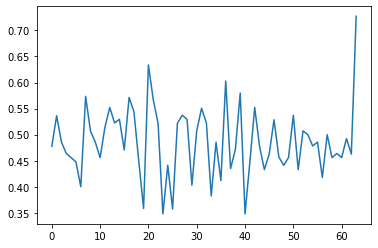

In [107]:
pylab.plot(np.arange(len(wd_s)), wd_s)

### Только для тестового датасета

In [125]:
wd_s = []
pk_s = []
ncms = []
segmentations = []
for i in (range(len(test_gaps))):
    seg = test_gaps[i]
    segmentation, ncm = compute_rand_segmentation_for_document(i, min_contact_points = 0, dynamic_contact_threshold_multiplier = 0.11)
    ncms.append(ncm)
    segmentations.append(segmentation)
    
    wd_s.append(windowdiff(seg, segmentation, 3))
    pk_s.append(pk(seg, segmentation, 3))

wd_mean = np.array(wd_s).mean()
pk_mean = np.array(pk_s).mean()

In [126]:
print(f"wd mean {wd_mean}")
print(f"pk mean {pk_mean}")

wd mean 0.4789170482265531
pk mean 0.4520103948355169


In [127]:
print(np.array(wd_s).mean())
print(np.array(wd_s).std())

0.4789170482265531
0.06702625200239902


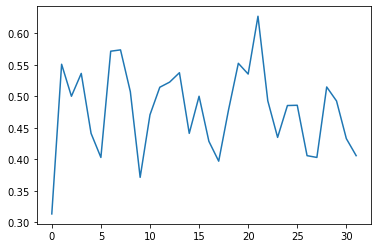

In [128]:
pylab.plot(np.arange(len(wd_s)), wd_s)

In [129]:
wd_s_random = cp(wd_s)

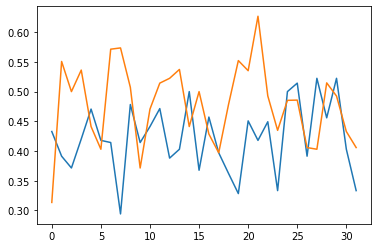

In [131]:
pylab.plot(np.arange(len(ws_s_real)), ws_s_real)
pylab.plot(np.arange(len(wd_s_random)), wd_s_random)
pylab.show()

In [350]:
wd_s = []
pk_s = []
segmentations = []
for i in (range(len(all_sentences_without_breaks))):
    doc = all_sentences_without_breaks[i]
    seg = all_true_segmentations[i]
    segmentation = rand_seg(len(seg), 0.803)
    segmentations.append(segmentation)
    
    wd_s.append(windowdiff(seg, segmentation, 3))
    pk_s.append(pk(seg, segmentation, 3))

wd_mean = np.array(wd_s).mean()
pk_mean = np.array(pk_s).mean()

In [209]:
# iou на этих графах не работает !! 

In [207]:
from utils import intersection
from utils import union

In [208]:
def estimate_gap_graph_sim(doc_idx, sent_1_idx, sent_2_idx):
    graph_1 = all_sentence_graphs[doc_idx][sent_1_idx]
    graph_2 = all_sentence_graphs[doc_idx][sent_2_idx]

    graph_sim = 1 - len(intersection(graph_1.nodes(), graph_2.nodes())) / len(union(graph_1.nodes(), graph_2.nodes()))

    return 1 - graph_sim

In [201]:
def calculate_gaps_for_sentences(text_id, sentences, estimation_method,
                                 args = {}):
    gaps = []
    for sentence_ind in range(len(sentences) - 1):
        gap = estimation_method(
            text_id,
            sentence_ind,
            sentence_ind + 1,
            **args)
        gap += estimation_method(
            text_id,
            sentence_ind,
            sentence_ind + 1,
            **args)
        gap /= 2.0
        gaps.append(gap)
    return gaps

In [202]:
gaps_for_all = []

for i in tqdm(range(len(all_true_breaks))):
    
    sentences_without_breaks = all_sentences_without_breaks[i]
    gaps = calculate_gaps_for_sentences(i, sentences_without_breaks, 
                                        estimate_gap_graph_sim, 
                                       )
    gaps_for_all.append(gaps)

100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 615.67it/s]


In [203]:
cutoffs_to_mean_match = []

for cutoff in tqdm(np.arange(0,1,0.01)):
    
    wnds = []
    pk_s = []
    for i in range(len(all_true_breaks)):
        gaps = gaps_for_all[i]
        true_segment_breaks = all_true_breaks[i]
        
        
        wnd, pk_ = find_matching_for_testing_file(sentences_without_breaks, true_segment_breaks, gaps, cutoff)
        
        wnds.append(wnd)
        pk_s.append(pk_)
        
    wnds = np.array(wnds)
    pk_s = np.array(pk_s)
    cutoffs_to_mean_match.append([cutoff, wnds.mean(), pk_s.mean()])

cutoffs_to_mean_match = np.array(cutoffs_to_mean_match)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 56.87it/s]


In [205]:
min_pos = cutoffs_to_mean_match[:,1].argmin()
print(f"min windowdiff\t\t{cutoffs_to_mean_match[min_pos][1]:.3f}")
print(f"coresp pk\t\t{cutoffs_to_mean_match[min_pos][2]:.3f}")
print(f"min pk\t\t\t{cutoffs_to_mean_match[:,2].min():.3f}")
print(f"opt cutoff\t\t{cutoffs_to_mean_match[min_pos][0]}")

min windowdiff		0.615
coresp pk		0.547
min pk			0.473
opt cutoff		0.07


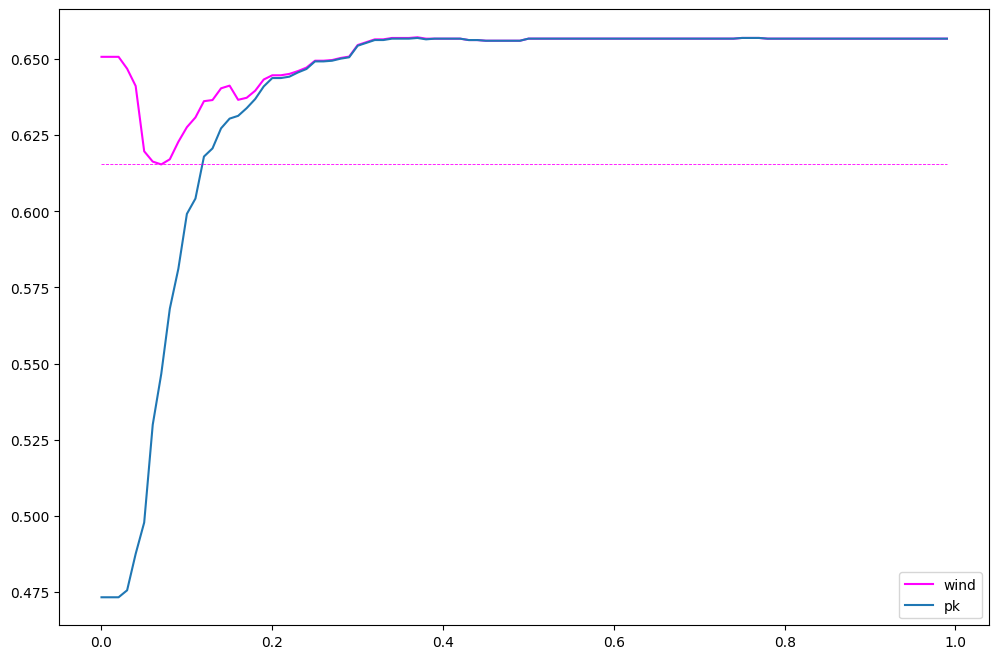

In [204]:
plot_cutoffs(cutoffs_to_mean_match)

0.0

In [132]:
pk(
    "000010000100001",
    "000100001000010",
    3
)

0.38461538461538464

In [137]:
pk(
    "0000100001000010000100001",
    "1111111111111111111111111",
    3
)

0.43478260869565216

In [135]:
pk(
    "000010000100001",
    "000000000000000",
    3
)

0.5384615384615384

In [139]:
pk(
    "000010000100001",
    "010100101001011",
    3
)

0.46153846153846156

In [145]:
pk(
    "000100001000100010001000100001000100010000100001000100010000100010000",
    "001000010001000100010001000010001000100001000010001000100001000100000", 3
    
)

0.44776119402985076

In [149]:
windowdiff(
    "000100001000100010001000100001000100010000100001000100010000100010000",
    "000000000000000000000000000000000000000000000000000000000000000000000", 3
    
)

0.6716417910447762

In [147]:
windowdiff(
    "000100001000100010001000100001000100010000100001000100010000100010000",
    "001000010001000100010001000010001000100001000010001000100001000100000", 3
    
)

0.44776119402985076

In [140]:

wd_s = []
pk_s = []
segmentations = []
for i in (range(len(all_sentences_without_breaks))):
    doc = all_sentences_without_breaks[i]
    seg = all_true_segmentations[i]
    segmentation = fixed_seg(len(seg), 1)
    segmentations.append(segmentation)

    wd_s.append(windowdiff(seg, segmentation, 3))
    pk_s.append(pk(seg, segmentation, 3))

wd_mean = np.array(wd_s).mean()
pk_mean = np.array(pk_s).mean()

In [143]:
for i in range(len(segmentations)):
    print(all_true_segmentations[i])
    print(segmentations[i])
    print(pk_s[i])
    print("================================")

000100001000100010001000100001000100010000100001000100010000100010000
111111111111111111111111111111111111111111111111111111111111111111111
0.3283582089552239
00001000010001000010000100001000010000100001000010000100001000100010000
11111111111111111111111111111111111111111111111111111111111111111111111
0.391304347826087
000100100001000010001000010001000010001000010000100010000100001000010000
111111111111111111111111111111111111111111111111111111111111111111111111
0.35714285714285715
00001000010001000100001000010000100010001000100001000010001000100001000
11111111111111111111111111111111111111111111111111111111111111111111111
0.34782608695652173
0000100001000100010001000100001000100001000010001000100010000100001000
1111111111111111111111111111111111111111111111111111111111111111111111
0.3382352941176471
000010000100010000100001000100001000100010000100010000100010001000100
111111111111111111111111111111111111111111111111111111111111111111111
0.3283582089552239
00001000100010000100010001000

integrate 1/(0.0088 * sqrt(2pi))*e^(-0.5*((x-0.472)/0.0088)^2) dx from -inf to x=0.440